In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from imblearn.over_sampling import SMOTENC

In [4]:
df = pd.read_excel('/home/sam/tirocinio/DB PAROTIDE DEF_corretto.xlsx', sheet_name='Sheet7')
df = df.loc[df['ESCLUDERE'] == 0]
df.reset_index(inplace = True)
df = df.loc[df['COD ISTO'] != 6]
df.reset_index(inplace = True)
df = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2','COD ISTO']]
df['ADC'] = df['ADC'].apply(lambda s: str(s).replace(',', '.')).astype(float)

In [5]:
y = df['COD ISTO'].copy()
X_not_encoded = df[['Segni macro malignità', 'ADC', 'TIC type', 'T2']].copy()
X = pd.get_dummies(X_not_encoded, columns = ['TIC type'])

In [16]:
def esperimento(X, y, tuned_parameters = {'criterion':['entropy'],'max_depth': list(range(2,9)),
                'min_samples_leaf': list(range(2,6)),'class_weight':['balanced']}, target_labels = (1,2),
                test_size = 0.2, model_selection = 'gridsearch', scoring_f = accuracy_score,
                cv= 2, random_state_tree = None, n_it = 10, smotenc_aug = False, print_trees = False):
    
    scores_ = []
    trees = []
    
    for n in range(n_it):
        
        print('### ITERATION %d ###\n\n' %(n+1))
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                            shuffle = True, stratify = y)
        
        print('## Dataset split completed ##')
        
        y_train = [1 if x in target_labels else 0 for x in y_train]
        y_test =  [1 if x in target_labels else 0 for x in y_test]
        
        if smotenc_aug == True:
            
            smt = SMOTENC(k_neighbors = 3, random_state=None, categorical_features=[0,2,3,4,5],
                          sampling_strategy = 'minority')
                
            X_train, y_train = smt.fit_resample(X_train, y_train)
                
            print('## SMOTENC augmentation completed ##')
        
        print('## Labels prepared ##')
        
        print('# Tuning hyper-parameters #\n')
            
        clf = tree.DecisionTreeClassifier(random_state = random_state_tree)
            
        scorer = None

        if scoring_f is f1_score:

            scorer = make_scorer(f1_score, average = 'weighted')
        else:
            scorer = make_scorer(scoring_f)


        if model_selection == 'gridsearch':

            clf = GridSearchCV(clf, tuned_parameters, scoring = scorer, cv = cv, refit = True)
            clf.fit(X_train, y_train)
            params = clf.best_params_
            score_ = clf.best_score_
            clf = clf.best_estimator_
            
        else:

            scores = cross_val_score(clf, X_train, y_train, scoring = scorer, cv = cv )
            clf = clf.fit(X_train, y_train)
            params = clf.get_params()
            score_ = scores.mean()
            
                
        print("Parameters set found:\n")
        print(params)
        print()
        print('Scoring function used: ')
        print(scorer)
        print("Cross-validated score of the estimator: %0.3f\n" %( score_))
        print('Scores on test set:')
        print(classification_report(y_test, clf.predict(X_test), zero_division = 0))
        
        selected_score = scorer(clf, X_test, y_test)
        print('Selected score on test set: {}'.format(selected_score))
           
        trees.append(clf)   
        scores_.append(selected_score)
            
        print('-'*100)
        
         
    print('\n\n### Mean final score: %0.3f , Std dev: %0.3f ###' %( np.mean(scores_), np.std(scores_)))
    
    if print_trees :
        
        print('\n\n### Best trees based on selected scoring function: ###')
        best_iteration = np.argmax(scores_)
        print('Referred iteration: {}'.format(best_iteration+1))
        
        fig, ax = plt.subplots(1,1)
        fig.set_size_inches(25, 15)
        
        t = trees[best_iteration]
        
        tree.plot_tree(t,
           feature_names = X.columns,
           class_names = ['0','1'], filled = True, rounded = True, ax = ax)
            

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.975

Scores on test set:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.80      0.89         5

    accuracy                           0.97        31
   macro avg       0.98      0.90      0.94        31
weighted avg       0.97      0.97      0.97        31

Selected score on test set: 0.9662541421518902
----------------------------------------------------------------------------------------------------
### ITERATION 2 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

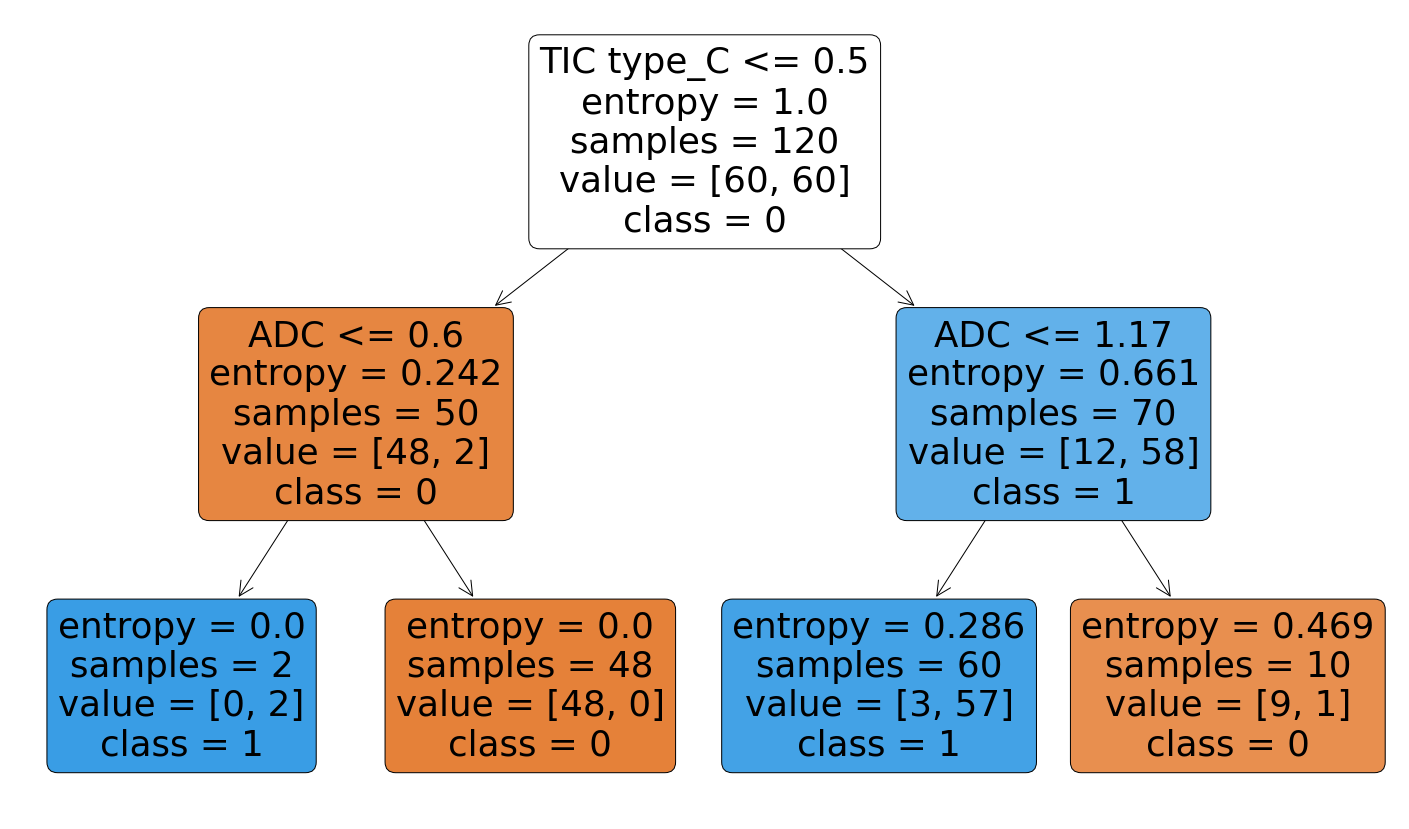

In [19]:
# 1,2 vs 3,4,5

seed = 42

esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, test_size = 0.3,
           print_trees = True)

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.975

Scores on test set:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        26
           1       0.71      1.00      0.83         5

    accuracy                           0.94        31
   macro avg       0.86      0.96      0.90        31
weighted avg       0.95      0.94      0.94        31

Selected score on test set: 0.9395698924731183
----------------------------------------------------------------------------------------------------
### ITERATION 2 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

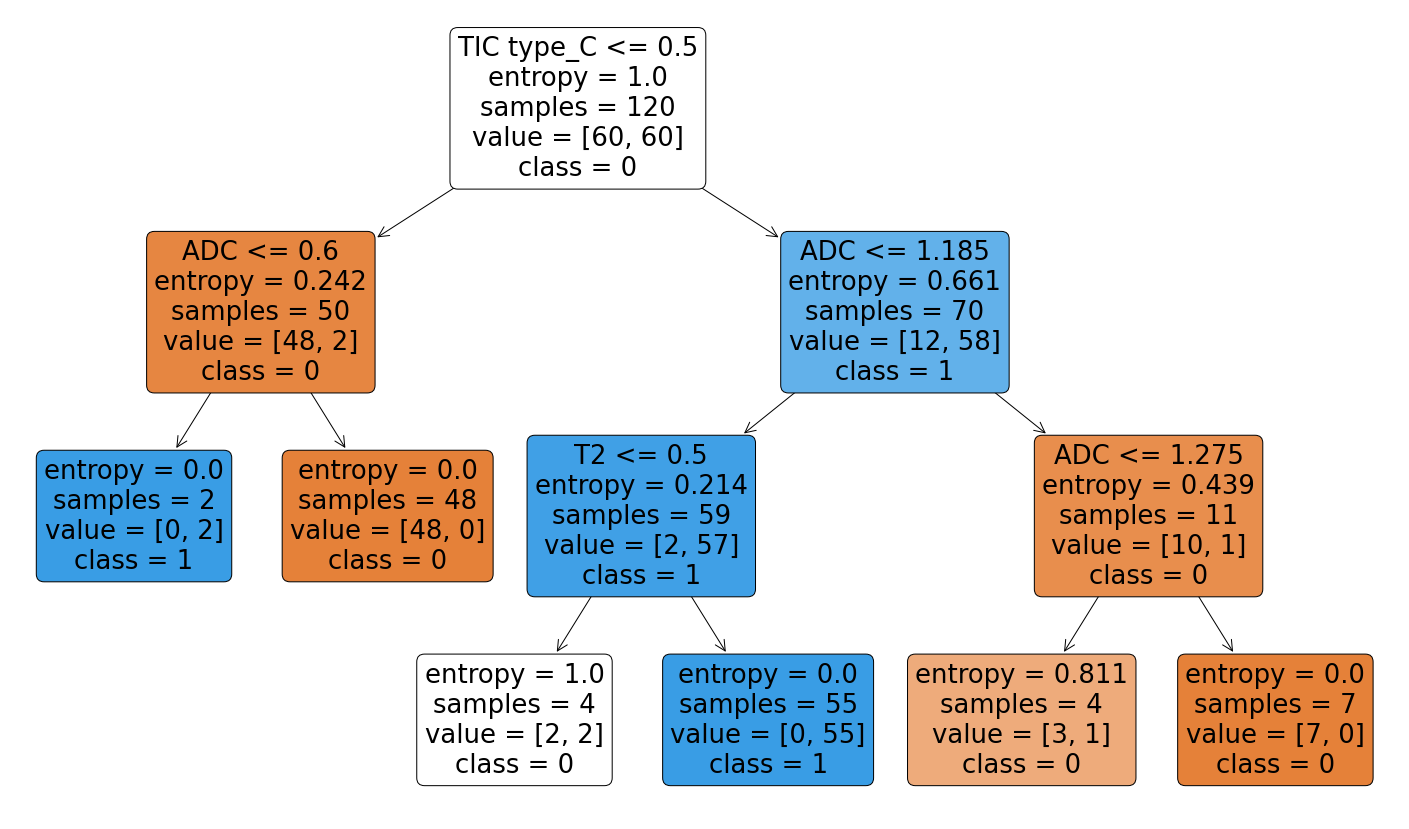

In [21]:
esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, test_size = 0.3,
           print_trees = True)

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

Scores on test set:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       1.00      0.60      0.75         5

    accuracy                           0.94        31
   macro avg       0.96      0.80      0.86        31
weighted avg       0.94      0.94      0.93        31

Selected score on test set: 0.9286140979689367
----------------------------------------------------------------------------------------------------
### ITERATION 2 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

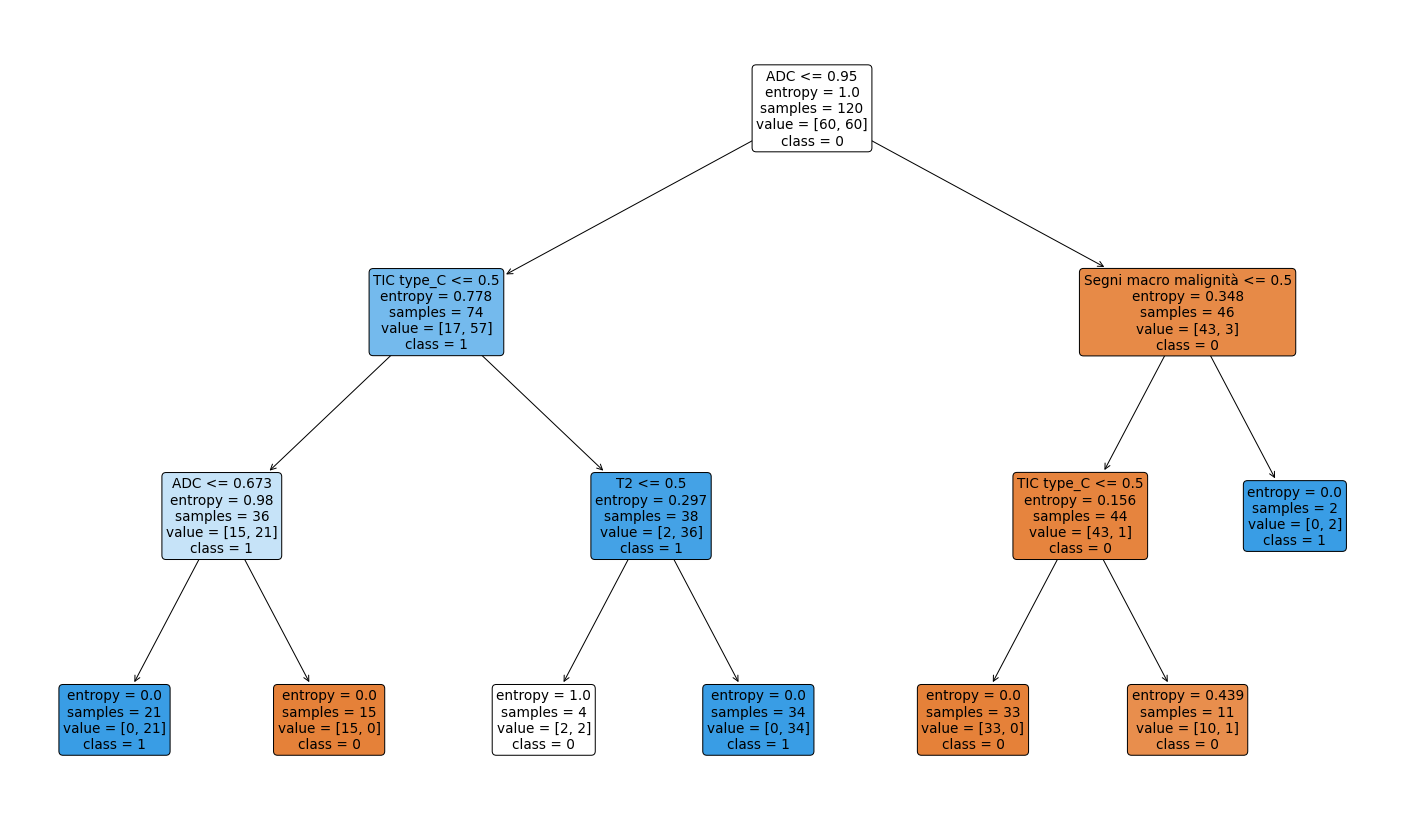

In [23]:
esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, test_size = 0.3,
           print_trees = True)

## mo proseguiamo con gli altri alberi

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.977

Scores on test set:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        27
           1       1.00      0.75      0.86         4

    accuracy                           0.97        31
   macro avg       0.98      0.88      0.92        31
weighted avg       0.97      0.97      0.97        31

Selected score on test set: 0.9657310431503979
----------------------------------------------------------------------------------------------------
### ITERATION 2 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

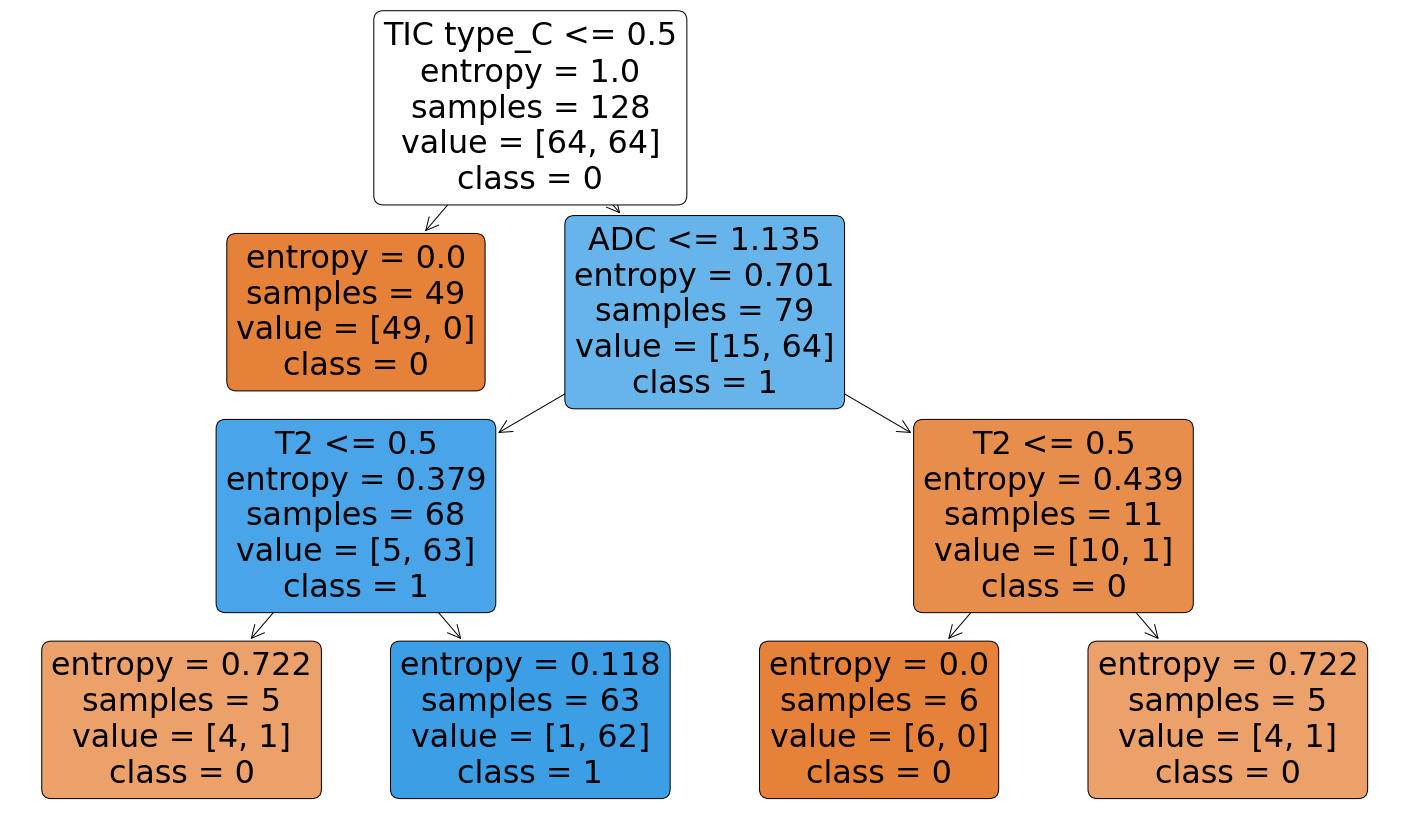

In [24]:
esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, test_size = 0.3,
           print_trees = True, target_labels = (1,))

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 1.000

Scores on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00         1

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Selected score on test set: 1.0
----------------------------------------------------------------------------------------------------
### ITERATION 2 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters se

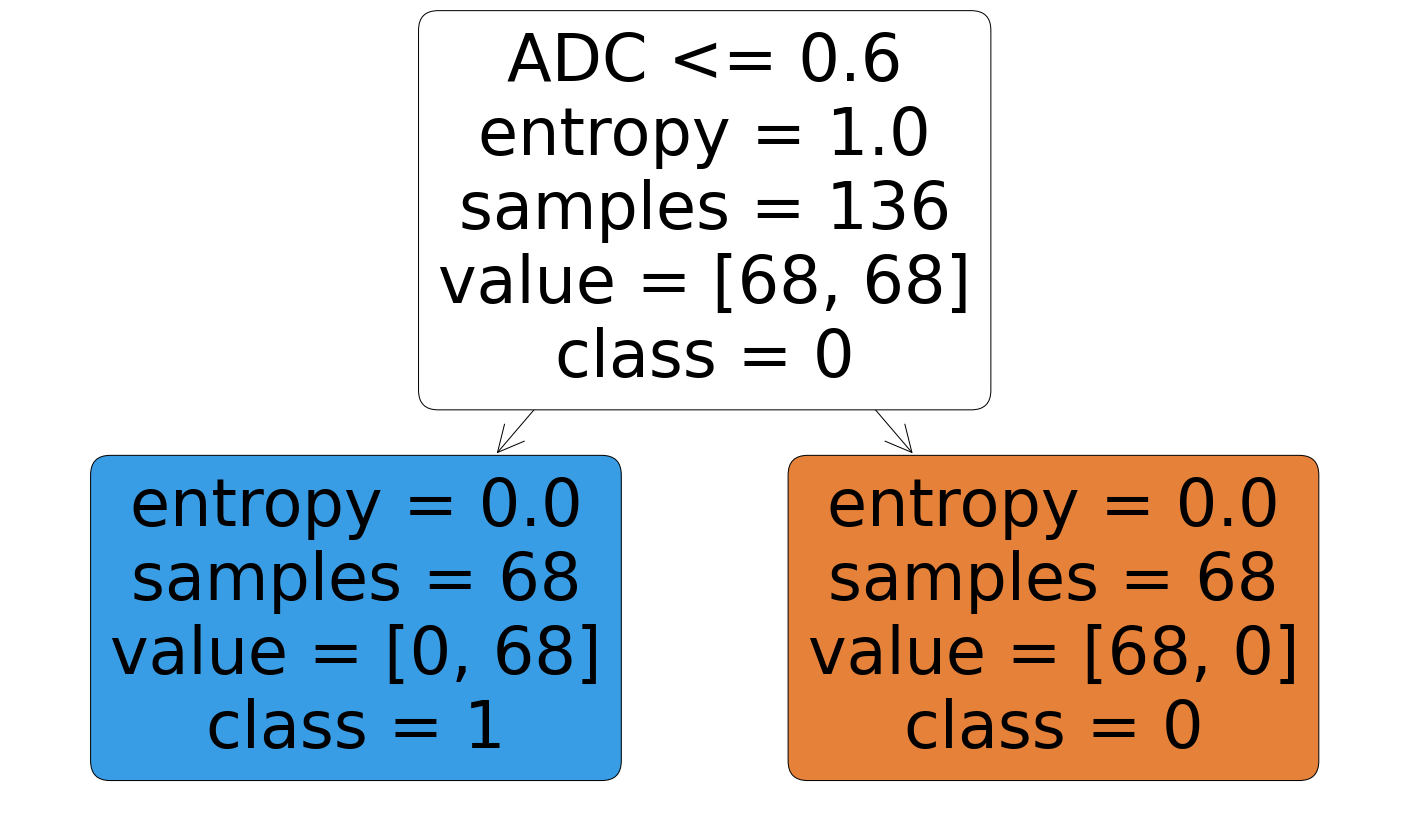

In [25]:
esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, test_size = 0.3,
           print_trees = True, target_labels = (2,))

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 5}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.891

Scores on test set:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       1.00      0.69      0.81        16

    accuracy                           0.84        31
   macro avg       0.88      0.84      0.84        31
weighted avg       0.88      0.84      0.84        31

Selected score on test set: 0.8352961256187063
----------------------------------------------------------------------------------------------------
### ITERATION 2 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

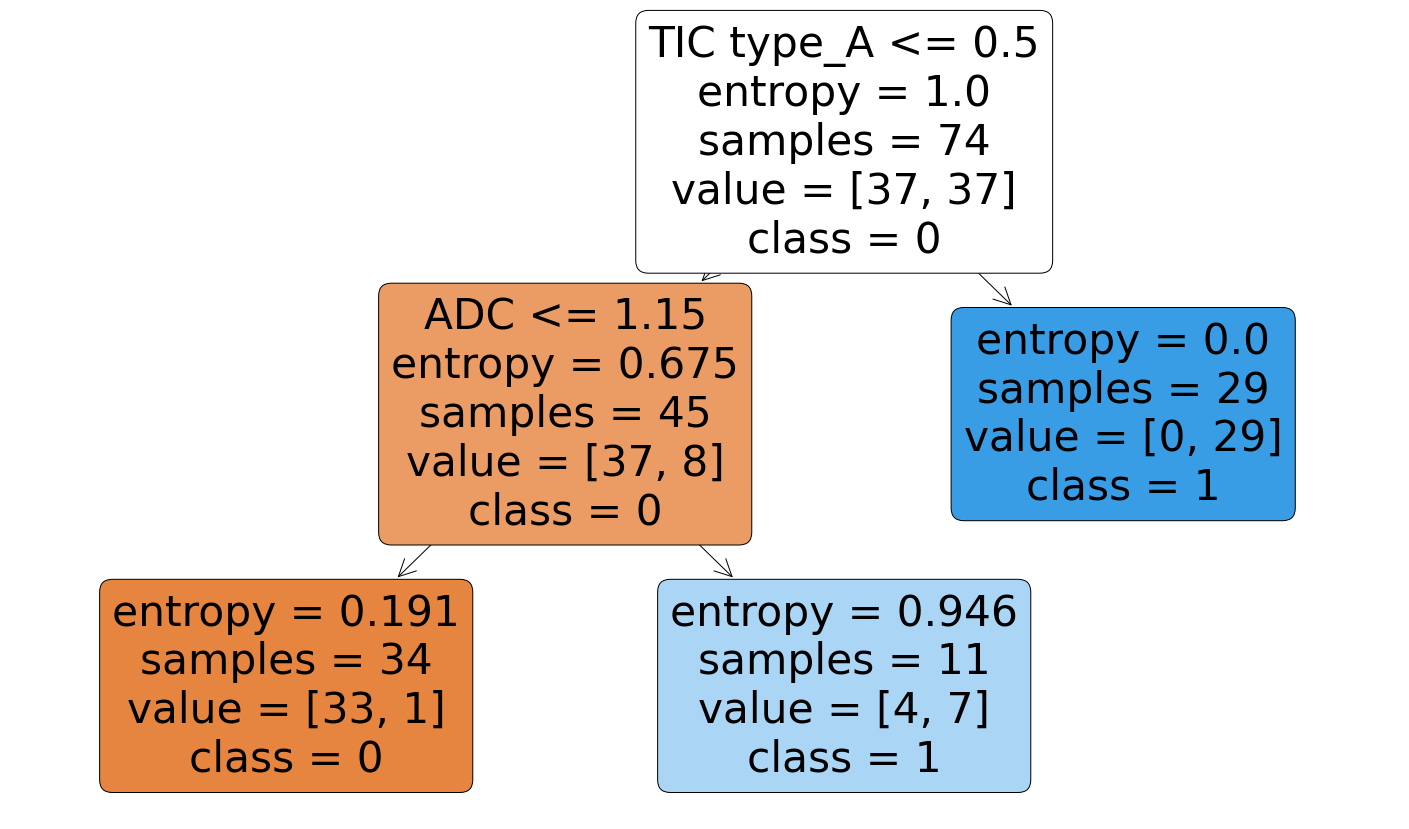

In [26]:
esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, test_size = 0.3,
           print_trees = True, target_labels = (3,))

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.981

Scores on test set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00         8

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Selected score on test set: 1.0
----------------------------------------------------------------------------------------------------
### ITERATION 2 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters se

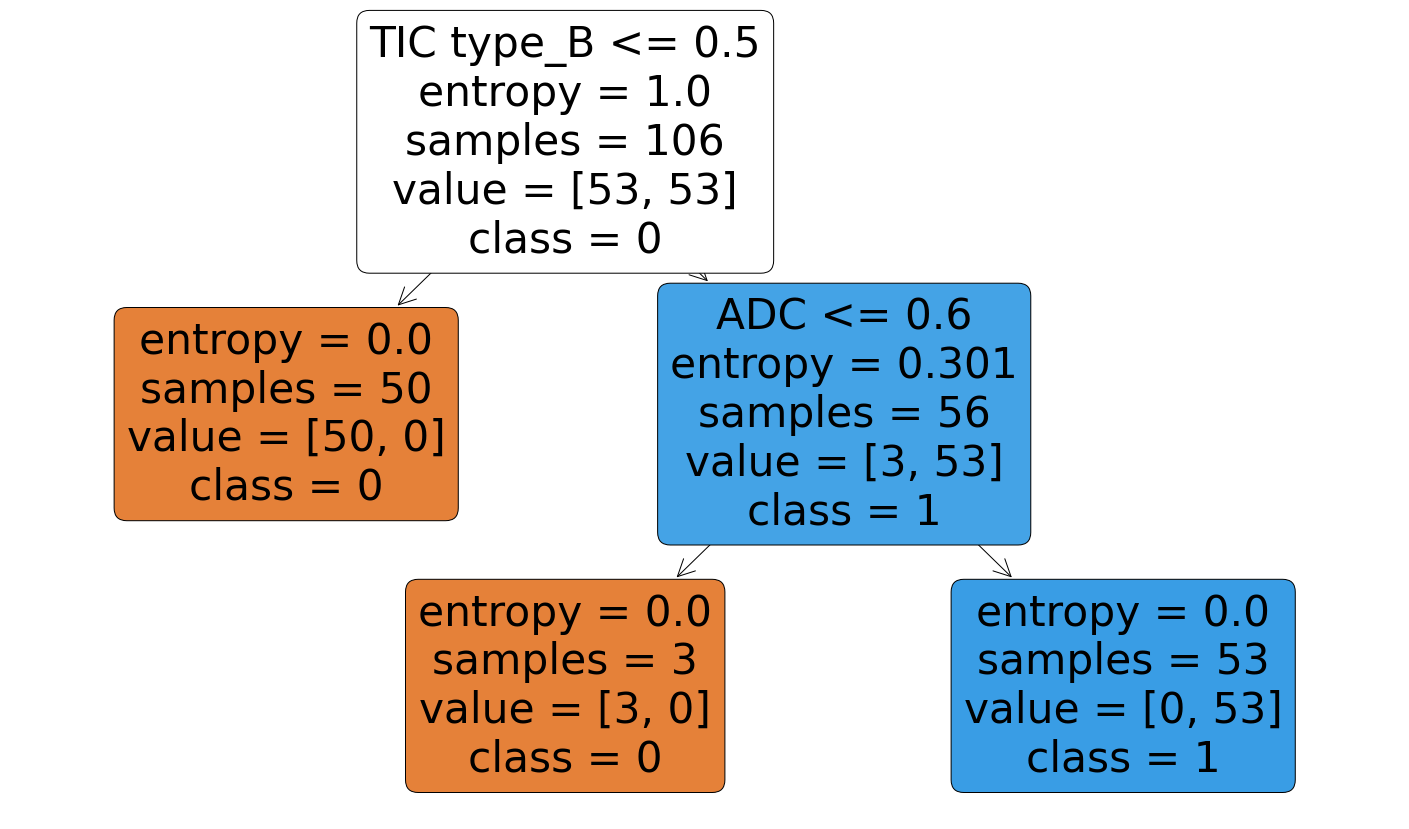

In [27]:
esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, test_size = 0.3,
           print_trees = True, target_labels = (4,))

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.948

Scores on test set:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        29
           1       0.40      1.00      0.57         2

    accuracy                           0.90        31
   macro avg       0.70      0.95      0.76        31
weighted avg       0.96      0.90      0.92        31

Selected score on test set: 0.9213238374528697
----------------------------------------------------------------------------------------------------
### ITERATION 2 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

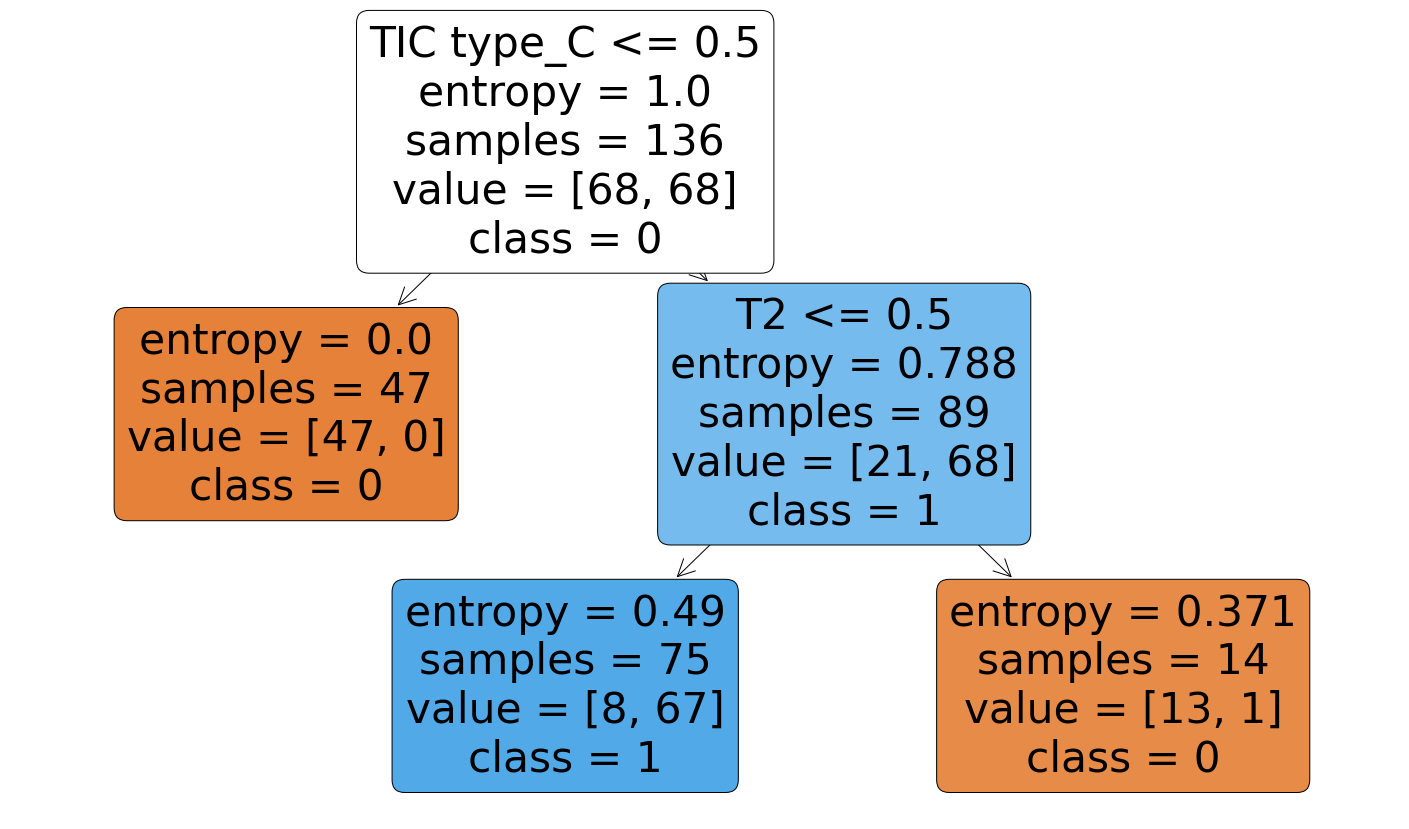

In [28]:
esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, test_size = 0.3,
           print_trees = True, target_labels = (5,))

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(accuracy_score)
Cross-validated score of the estimator: 0.933

Scores on test set:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        26
           1       1.00      0.60      0.75         5

    accuracy                           0.94        31
   macro avg       0.96      0.80      0.86        31
weighted avg       0.94      0.94      0.93        31

Selected score on test set: 0.9354838709677419
----------------------------------------------------------------------------------------------------
### ITERATION 2 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters

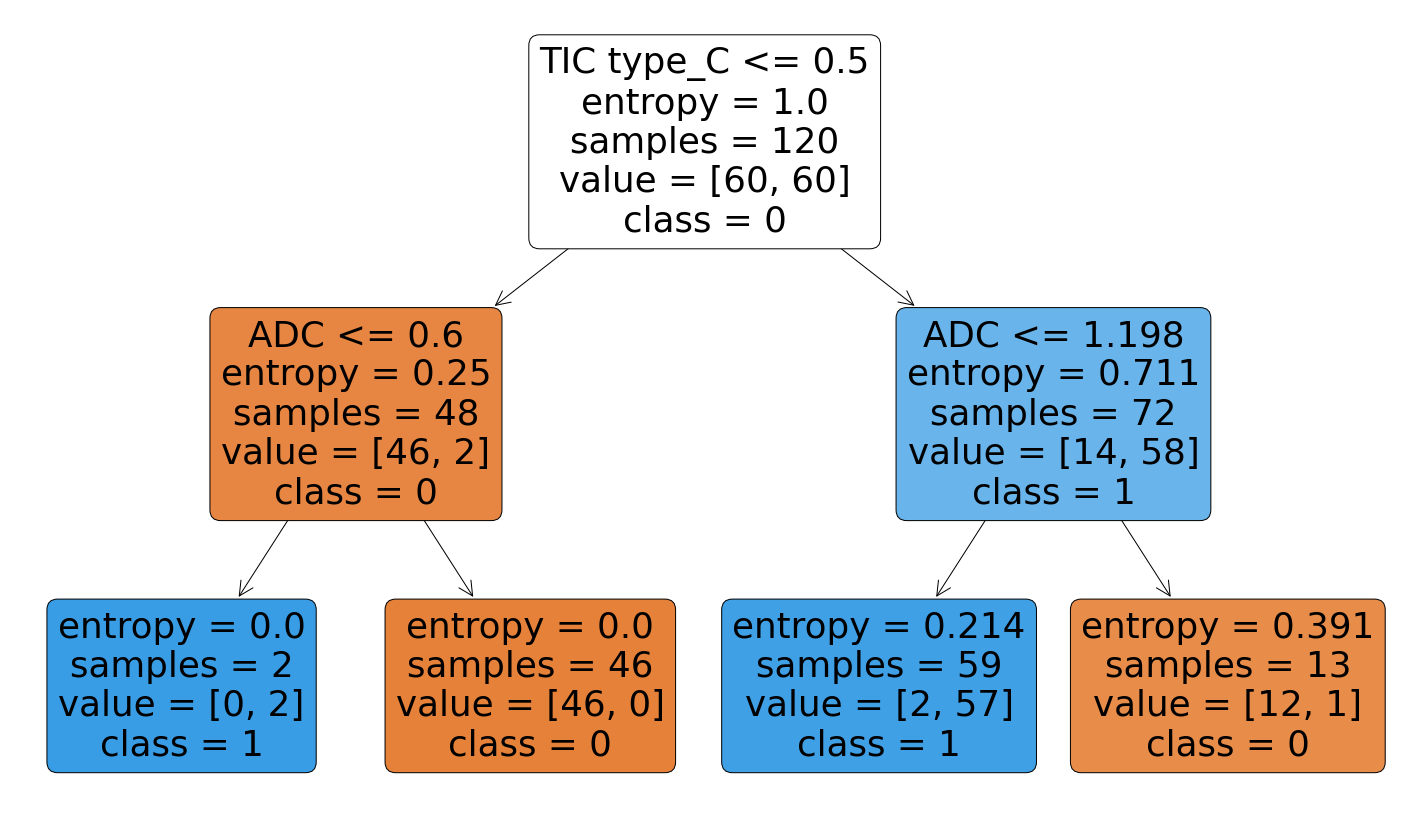

In [29]:
#gioco ancora con maligni vs benigni, mo uso l'accuratezza

esperimento(X, y, random_state_tree = seed, smotenc_aug = True, test_size = 0.3,
           print_trees = True)

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.967

Scores on test set:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        26
           1       1.00      0.80      0.89         5

    accuracy                           0.97        31
   macro avg       0.98      0.90      0.94        31
weighted avg       0.97      0.97      0.97        31

Selected score on test set: 0.9662541421518902
----------------------------------------------------------------------------------------------------
### ITERATION 2 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Para

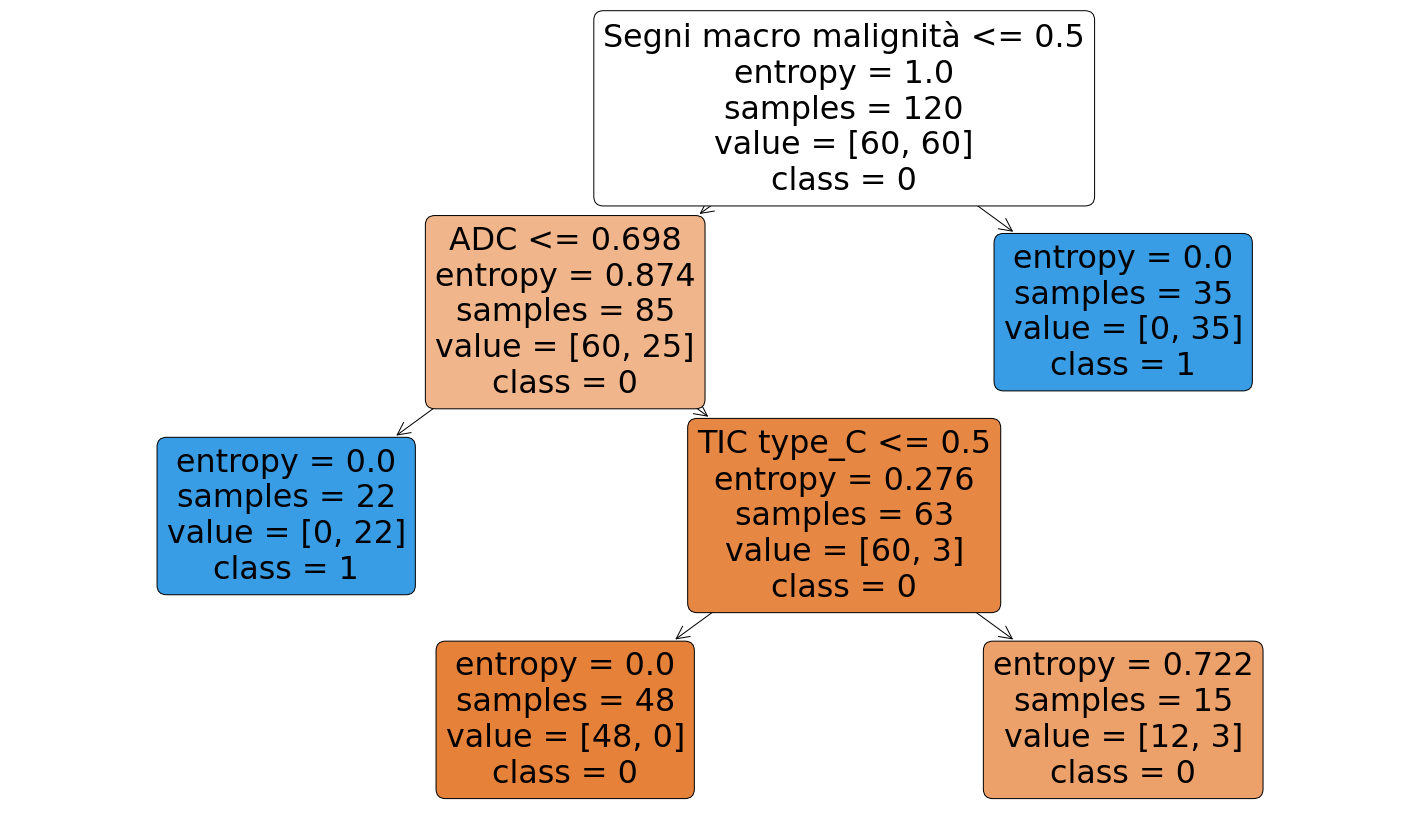

In [30]:
#maligni vs benigni ma non bilancio il peso delle classi

esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, test_size = 0.3,
           print_trees = True, tuned_parameters = {'criterion':['entropy'],'max_depth': list(range(2,9)),
                'min_samples_leaf': list(range(2,6)),'class_weight':[None]})

### ITERATION 1 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Parameters set found:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 2}

Scoring function used: 
make_scorer(f1_score, average=weighted)
Cross-validated score of the estimator: 0.992

Scores on test set:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        26
           1       1.00      0.40      0.57         5

    accuracy                           0.90        31
   macro avg       0.95      0.70      0.76        31
weighted avg       0.91      0.90      0.89        31

Selected score on test set: 0.8851277754503561
----------------------------------------------------------------------------------------------------
### ITERATION 2 ###


## Dataset split completed ##
## SMOTENC augmentation completed ##
## Labels prepared ##
# Tuning hyper-parameters #

Para

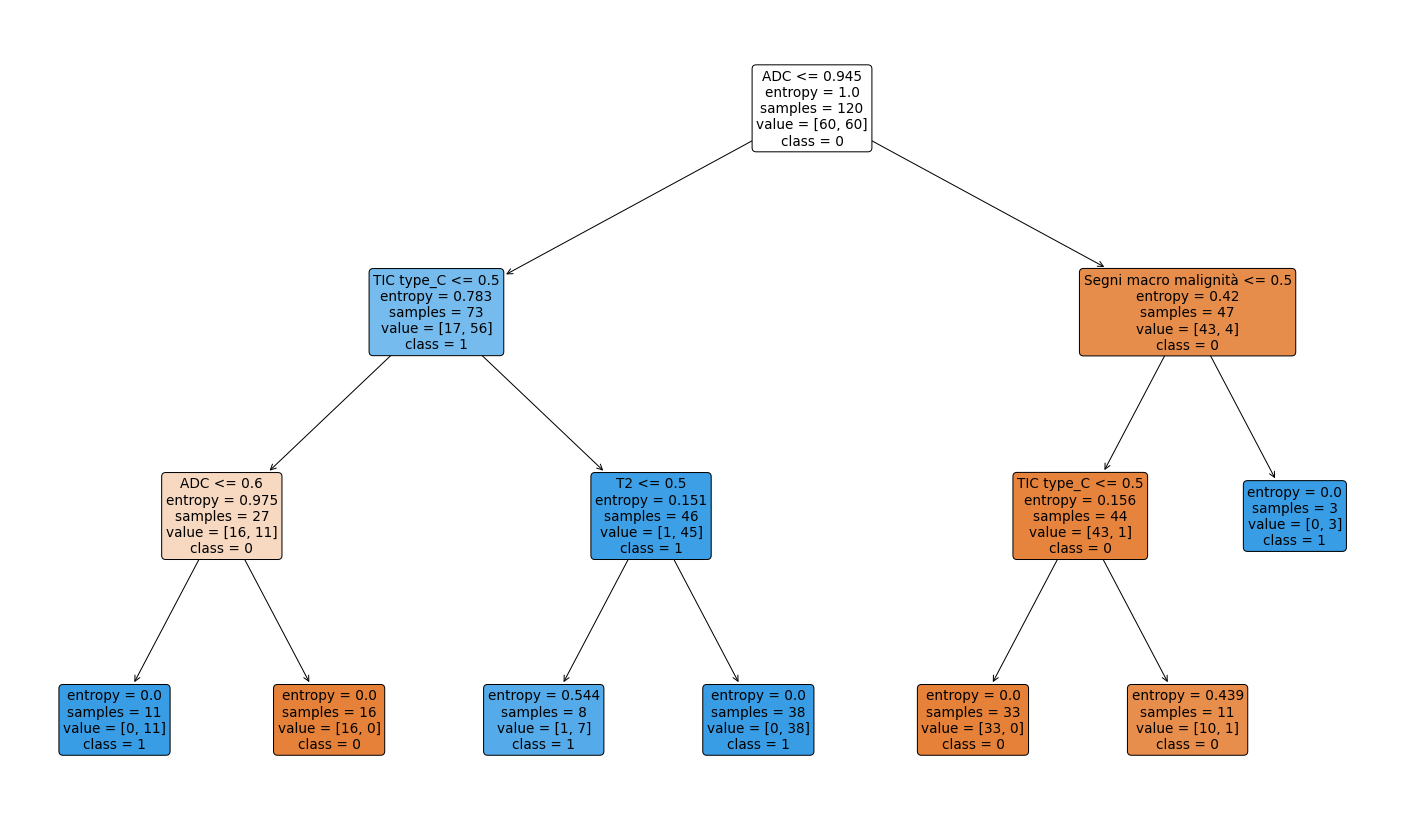

In [31]:
esperimento(X, y, random_state_tree = seed, smotenc_aug = True, scoring_f = f1_score, test_size = 0.3,
           print_trees = True, tuned_parameters = {'criterion':['entropy'],'max_depth': list(range(2,9)),
                'min_samples_leaf': list(range(2,6)),'class_weight':[None]})